In [1]:
import os
import sys

import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as stm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
from pandas import read_csv

In [16]:
%%javascript
    MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });

<IPython.core.display.Javascript object>

In [27]:
def ts_plot(y,lags=None,title1='',figsize=(10, 8),style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots' + title1)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        stm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

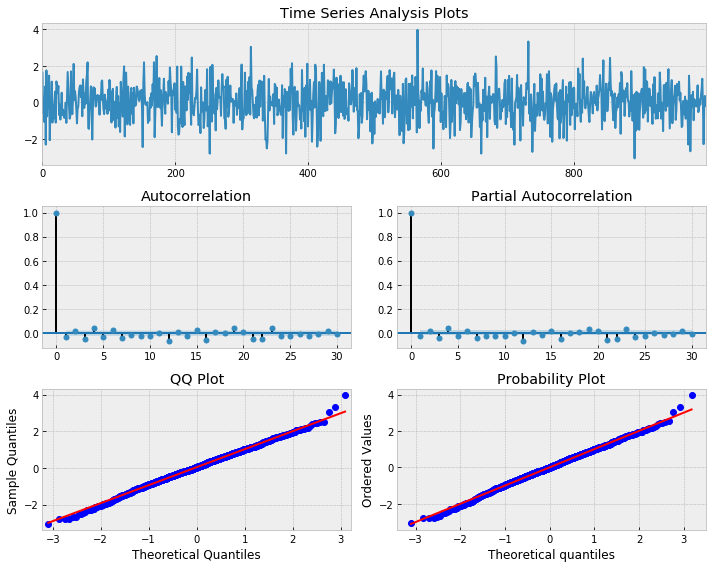

In [4]:
np.random.seed(1)

# plot of discrete white noise
rand_t = np.random.normal(size=1000)
ts_plot(rand_t, lags=30)

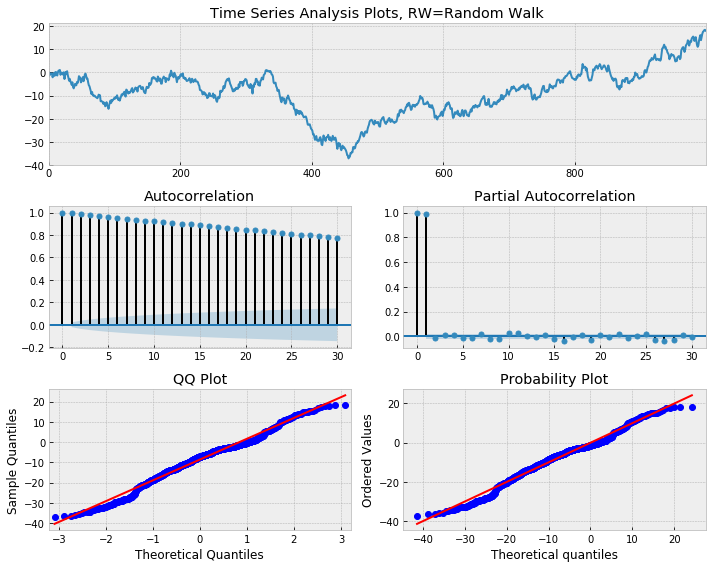

In [32]:
# Random Walk without a drift

np.random.seed(30)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

f = ts_plot(x,lags=30,title1=', RW=Random Walk')   # 


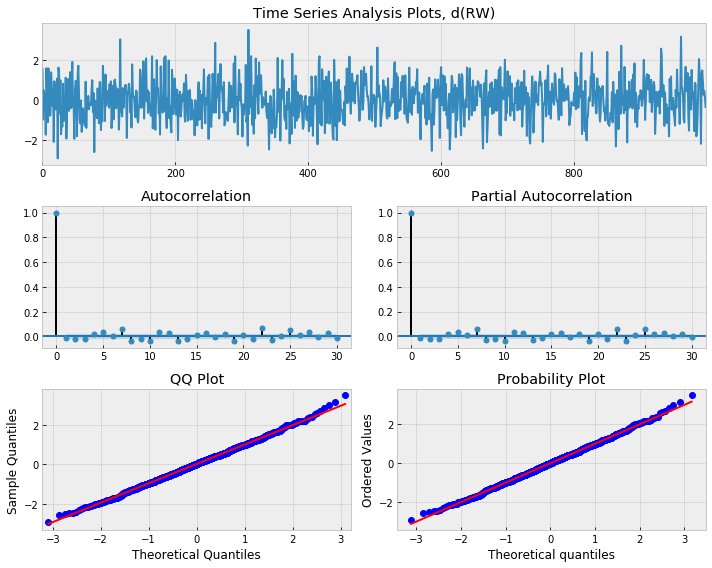

In [38]:
# let us confirm that we can recover a stationary white noise from the random walk above by taking
# a difference
_ = ts_plot(np.diff(x), lags=30,title1=', d(RW)')

In [7]:
# read SPY data (SPY is a S&P500 ETF, which is a proxy of the S&P500 cash index)    
s_tn = read_csv('spy_dt_wk_1993_2017.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)  #, date_parser=parser
p_t=s_tn['Close']     # just get the closing prices
print(s_tn.head())

            Time   Open   High    Low  Close      Vol
Date                                                 
1993-02-05  1600  44.23  45.10  44.13  44.97  1754300
1993-02-12  1600  44.97  45.13  44.53  44.60  1159800
1993-02-19  1600  44.47  44.47  42.82  43.57   998700
1993-02-26  1600  43.70  44.44  43.48  44.42  1024300
1993-03-05  1600  44.56  45.20  44.23  44.75   658500


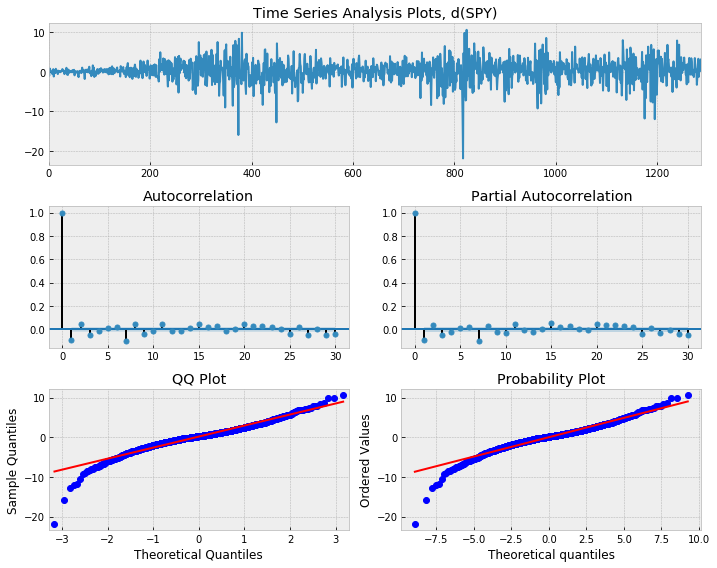

In [37]:
# calculate return series
pr_t=p_t.pct_change(1)
dp_t=np.diff(p_t)

# now plot the diff of prices
ts_plot(dp_t, lags=30,title1=', d(SPY)')   # np.diff(p_t)  # _ = 

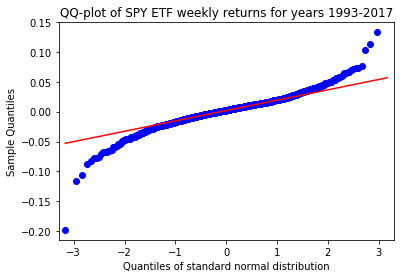

In [11]:
# make a qq-plot against a standard distribution of some type
#fig9 = plt.figure()
stm.qqplot(pr_t, line='q')    # , stats.t, distargs=(5,) #, line='45' 

plt.title('QQ-plot of SPY ETF weekly returns for years 1993-2017')
plt.xlabel('Quantiles of standard normal distribution')

# Autoregressive Models - AR(p)


$$x_t=\alpha_1 x_{t-1} + \alpha_2 x_{t-2} + ... + \alpha_p x_{t-p} + \omega_t=  $$
\begin{equation}
=\sum_{i=1}^p \alpha_i x_{t-i} + \omega_t      
\end{equation}

Here $\alpha_i$ are the model coefficients and $\omega_t$ is a white noise term. The simplest models AR(1), AR(2) are as follows: 
\begin{equation}
    x_t=\alpha_1 x_{t-1} + \omega_t
\end{equation}
\begin{equation}
    x_t=\alpha_1 x_{t-1} + \alpha_2 x_{t-2} + \omega_t
\end{equation}


Let us generate AR(1) sample with $\alpha_1=0.3$ and then fit AR(p) model, recovering $\alpha_1$ coefficient and the order of best model $p$.

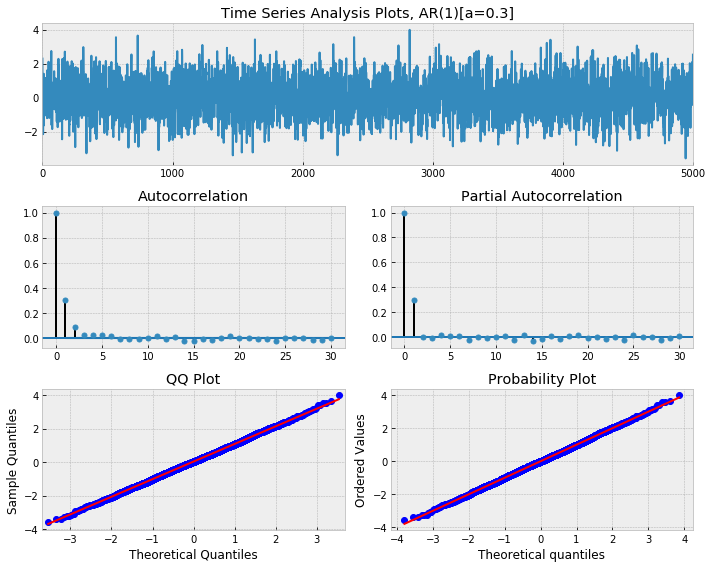

In [40]:
# generate AR(1) sample with alpha = 0.3

np.random.seed(1)
N = int(5000)
a = 0.3
x = w = np.random.normal(size=N)

for t in range(N):
    x[t] = a*x[t-1] + w[t]
    
_ = ts_plot(x, lags=30,title1=', AR(1)[a=0.3]')


There is a significant correlation at lag=1, as seen in the PACF plot. This is, of course, what we would expect from an 
AR(1) process. Now, let us fit this data with AR(p) process from Python statsmodels.

In [45]:
# fit an AR(p) model to simulated AR(1) process with alpha = 0.3
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
p_est = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')   # %time 

In [47]:
p_true = 1   # true order or AR(1) process used to generate the time series
p('\n alpha-est: {:3.5f}, p-est = {}'.format(mdl.params[0], p_est))
p('\n alpha-true = {}, p-true = {}'.format(a, p_true))


 alpha-est: 0.30068, p-est = 1

 alpha-true = 0.3, p-true = 1


We see that, AR(1) parameters $\alpha_1$ and $p$ are found correctly! Let us continue with AR(2) in a more general fashion (to be useful for ARIMA modeling later).

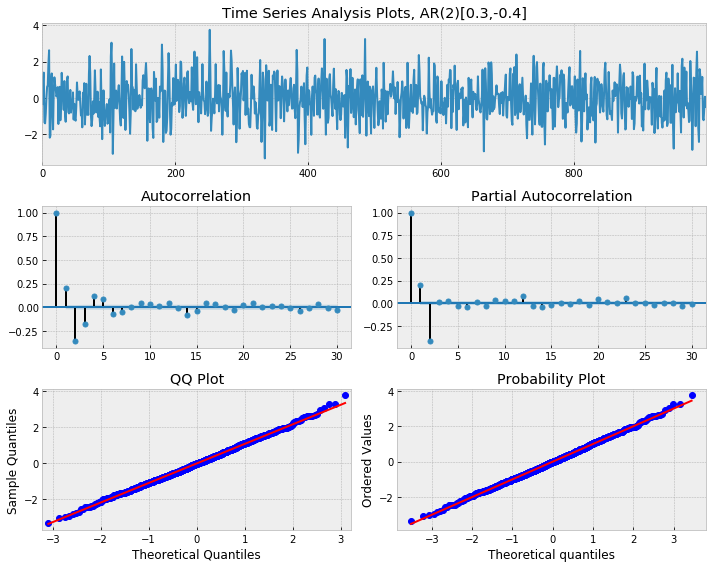

In [103]:
# generate AR(2) time series
n = int(1000)
alpha_n = np.array([0.3, -0.4])
beta_n = np.array([0.])      # set the betas for the MA equal to 0 for an AR(p) model

ar = np.r_[1, -alpha_n]    # note the minus sign in front of alpha_n, zero-lag value of 1
ma = np.r_[1, beta_n]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
ts_plot(ar2, lags=30,title1=', AR(2)[0.3,-0.4]')


Let us see if we can recover AR(2) process parameters with Python statsmodels.

In [114]:
# fit an AR(p) model to simulated AR(2) process
p_max = 10
mdl = smt.AR(ar2).fit(maxlag=p_max, ic='aic', trend='nc')   # , ic='aic'  't-stat'
p_est = smt.AR(ar2).select_order(maxlag=p_max, ic='aic', trend='nc')

In [115]:
p_true = 2
p('\ncoef estimate: {:3.2f} {:3.2f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], p_est))
p('\ntrue coefs = {} | true order = {}'.format([0.3,-0.4],p_true))


coef estimate: 0.29 -0.42 | best lag order = 2

true coefs = [0.3, -0.4] | true order = 2


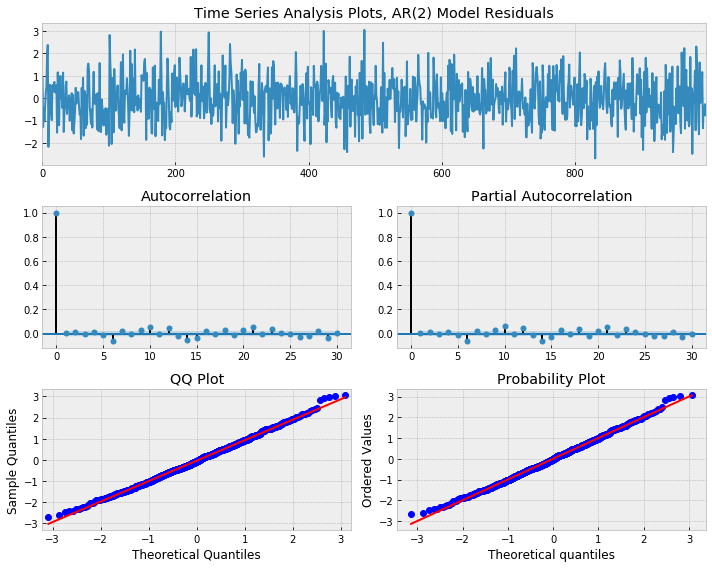

In [119]:
ts_plot(mdl.resid, lags=30,title1=', AR(2) Model Residuals')   #type(ar2)    #plt.plot(mdl.resid)

In [121]:
scs.normaltest(mdl.resid)

NormaltestResult(statistic=3.5783897569284906, pvalue=0.16709464702329641)

From the plot of residuals above (and its ACF and PACF), we can see that they look like Gaussian noise. Pearson normality test with p-value being 0.17 confirms that, the data most likely came from the normal distribution.

We can try to fit SPY returns by the AR(p) model. Let us see what happens: 

In [123]:
# fit an AR(p) model to SPY returns
p_max = 50
mdl = smt.AR(dp_t).fit(maxlag=p_max, ic='aic', trend='nc')   # , ic='aic'  't-stat'
p_est = smt.AR(dp_t).select_order(maxlag=p_max, ic='aic', trend='nc')

In [124]:
p('p_est=',p_est)

p_est= 33


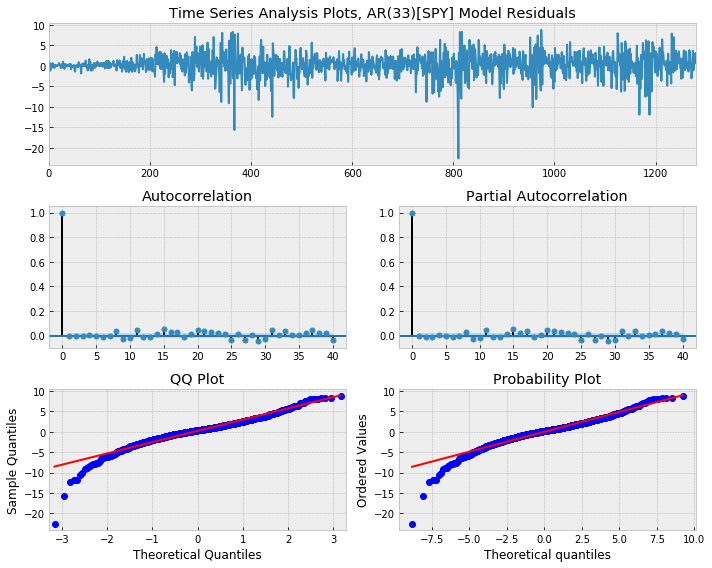

In [125]:
ts_plot(mdl.resid, lags=40,title1=', AR(33)[SPY] Model Residuals') 

We see that, trying to fit SPY returns with AR(p) requires 33 lags. The model seems to be too complex, plus, it does not solve the volatility clustering problem.

# Moving Average Models - MA(q)

$$x_t=\beta_1 \omega_{t-1} + \beta_2 \omega_{t-2} + ... + \beta_p \omega_{t-p} + \omega_t=  $$
\begin{equation}
=\sum_{i=1}^p \beta_i \omega_{t-i} + \omega_t      
\end{equation}

ARMA(p,q) model is just a merge between AR(p) and MA(q) models. The usefulnes of ARMA modeling for finance lies in the following properties of AR and MA models:
-  AR(p) models explain the momentum and mean reversion effects often observed in trading markets
-  MA(q) models explain the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the time series: e.g. earning surprises, buyout/mergers, interest rate hikes, etc.

However, the problem with ARIMA models is that, they do not capture volatility clustering effects. 

# ARMA Models - ARMA(p,q)
$$x_t=\alpha_1 x_{t-1} + \alpha_2 x_{t-2} + ... + \alpha_p x_{t-p} + \omega_t + \beta_1 \omega_{t-1} + \beta_2 \omega_{t-2} + ... + \beta_q \omega_{t-q}=  $$
\begin{equation}
=\sum_{i=1}^p \alpha_i x_{t-i} + \omega_t + \sum_{i=1}^q \beta_i \omega_{t-i}     
\end{equation}



In [ ]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)
